# **삼성 멀티캠퍼스 데이터 사이언스/엔지니어링 수업 실습**

본 분석 및 시각화는, 통계적으로 유의미한 결과를 출력에 목적이 있는 것이 아닙니다.
- pandas 및 seaborn 패키지 활용
- Python과 SQL 연동 및 SQL 연습
- ORM에 대한 이해

본문의 내용은 상기한 내용과 관련하여, 해당 툴에 대한 이해도 향상, 그리고 반복 및 숙달에 그 목적이 있습니다.

# World 데이터베이스의 테이블을 보고, Python에서 분석 및 시각화
- 주제 : 국가의 GNP별 기대수명 상관관계 확인

## 패키지 및 데이터 불러오기

### SQL Alchemy 불러오기

In [ ]:
!pip install mysqlclient

     |████████████████████████████████| 87 kB 3.3 MB/s 
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99964 sha256=7f402508752fa7d227c046d0a471f078a7654b6275124bc1546115b0a54898f4
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
Successfully built mysqlclient


In [ ]:
from sqlalchemy import *
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import func

### sqldb 불러오기

seaborn 이용한 시각적 분석을 위해, sqldb를 통해 데이터프레임 형식으로 country 테이블을 저장하였다.

In [ ]:
!pip install mysqlclient

In [ ]:
import MySQLdb

In [ ]:
HOST = "#######"

db = MySQLdb.connect(
    HOST,
    "###",
    "###",
    "world"
)
db

In [ ]:
QUERY = """
 SHOW
 TABLES;
"""
cursor = db.cursor()
cursor.execute(QUERY)

3

In [ ]:
cursor.fetchall()

(('city',), ('country',), ('countrylanguage',))

In [ ]:
import pandas as pd

QUERY = """
  SELECT *
  FROM country
"""

In [ ]:
df_country = pd.read_sql(QUERY, db)
df_country.head()

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,ABW,Aruba,North America,Caribbean,193.0,NaN,103000,78.4,828.0,793.0,Aruba,Nonmetropolitan Territory of The Netherlands,Beatrix,129.0,AW
1,AFG,Afghanistan,Asia,Southern and Central Asia,652090.0,1919.0,22720000,45.9,5976.0,NaN,Afganistan/Afqanestan,Islamic Emirate,Mohammad Omar,1.0,AF
2,AGO,Angola,Africa,Central Africa,1246700.0,1975.0,12878000,38.3,6648.0,7984.0,Angola,Republic,José Eduardo dos Santos,56.0,AO
3,AIA,Anguilla,North America,Caribbean,96.0,NaN,8000,76.1,63.2,NaN,Anguilla,Dependent Territory of the UK,Elisabeth II,62.0,AI
4,ALB,Albania,Europe,Southern Europe,28748.0,1912.0,3401200,71.6,3205.0,2500.0,Shqipëria,Republic,Rexhep Mejdani,34.0,AL


### pandas, numpy, seaborn 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] =(8, 5)

### SQL world 테이블 불러오기

In [ ]:
# AWS 및 MySQL 접속 정보 불러오기
HOST = "####"
DE_USER = "####"
DB_PASSWD = "####"
DB_NAME = "world"
connection = f"mysql://{DE_USER}:{DB_PASSWD}@{HOST}/{DB_NAME}?charset=utf8"
print(connection)

In [ ]:
# 엔진 생성
engine = create_engine(connection)
engine

OldGNP, 국가 원수 이름, 해당 국민이 자국을 부르는 명칭, 면적 등은 조회하지 않기로 한다.

In [ ]:
# 테이블 객체 생성

Base = declarative_base()

class Country(Base):

  __tablename__ = "country"

  Code           = Column(String(3),primary_key = True)
  Name           = Column(String(52))
  Continent      = Column(String(100))
  Region         = Column(String(100))
  Population     = Column(Integer)
  LifeExpectancy = Column(Integer)
  GNP            = Column(Integer)
  GovernmentForm = Column(String(100))

  def __init__(self, Code, Name, Continent, Region, Population, LifeExpectancy, GNP, GovernmentForm):
    self.Code           = Code
    self.Name           = Name
    self.Continent      = Continent
    self.Region         = Region
    self.Population     = Population
    self.LifeExpectancy = LifeExpectancy
    self.GNP            = GNP
    self.GovernmentForm = GovernmentForm

  def __repr__(self):
    return "<Country {}, {}, {}, {}, {}, {}, {}, {}>".format(self.Code, self.Name, self.Continent, self.Region, self.Population, self.LifeExpectancy, self.GNP, self.GovernmentForm)

In [ ]:
# engine에 연결된 데이터베이스(world db)에 테이블 생성
Base.metadata.create_all(engine)

In [ ]:
# 데이터베이스 세션 연결
Session = sessionmaker(engine)
ses = Session()
ses

In [ ]:
Session = sessionmaker(engine)
ses = Session()
result = ses.query(Country).all()
print(len(list(result)))

# 원본의 239열과 결과물의 크기가 같은 것을 통해, 원본 테이블이 잘 로드되었음을 확인할 수 있다.

239


## world 테이블의 데이터 분석

### GNP 하위 20개국 목록 파악

우선, GNP 하위 20개 국가들의 목록을 파악하고자 하였다.

목록은 `국가코드, 국가명, 대륙, 지역, 인구, 기대수명, GNP, 정부형태` 순이다.

In [ ]:
result = ses.query(Country).order_by(Country.GNP).limit(20)
list(result)

[<Country TKL, Tokelau, Oceania, Polynesia, 2000, None, 0.00, Nonmetropolitan Territory of New Zealand>,
 <Country GRL, Greenland, North America, North America, 56000, 68.1, 0.00, Part of Denmark>,
 <Country CXR, Christmas Island, Oceania, Australia and New Zealand, 2500, None, 0.00, Territory of Australia>,
 <Country IOT, British Indian Ocean Territory, Africa, Eastern Africa, 0, None, 0.00, Dependent Territory of the UK>,
 <Country MYT, Mayotte, Africa, Eastern Africa, 149000, 59.5, 0.00, Territorial Collectivity of France>,
 <Country NIU, Niue, Oceania, Polynesia, 2000, None, 0.00, Nonmetropolitan Territory of New Zealand>,
 <Country CCK, Cocos (Keeling) Islands, Oceania, Australia and New Zealand, 600, None, 0.00, Territory of Australia>,
 <Country SGS, South Georgia and the South Sandwich Islands, Antarctica, Antarctica, 0, None, 0.00, Dependent Territory of the UK>,
 <Country PCN, Pitcairn, Oceania, Polynesia, 50, None, 0.00, Dependent Territory of the UK>,
 <Country ATF, French 

하지만 위 결과에는 문제가 있었다.

1. 정부 형태가 온전한 독립국이 아닌 속령이거나,
2. 인구가 없거나,
3. 기대수명 데이터가 없다.

### GNP 하위 20개국 재확인

인구수가 100만명 이상의 경우, 대부분 정부 형태가 독립국이며 기대수명 데이터 또한 수집 되어 있는 것으로 확인되어, 인구수 한가지 조건에 대하여 제약을 걸고 다시 GNP 하위 20개국 목록을 확인하였다.

In [ ]:
result = ses.query(Country).filter(Country.Population>=1000000).order_by(Country.GNP).limit(20)
list(result)

[<Country GNB, Guinea-Bissau, Africa, Western Africa, 1213000, 49.0, 293.00, Republic>,
 <Country GMB, Gambia, Africa, Western Africa, 1305000, 53.2, 320.00, Republic>,
 <Country BTN, Bhutan, Asia, Southern and Central Asia, 2124000, 52.4, 372.00, Monarchy>,
 <Country ERI, Eritrea, Africa, Eastern Africa, 3850000, 55.8, 650.00, Republic>,
 <Country SLE, Sierra Leone, Africa, Western Africa, 4854000, 45.3, 746.00, Republic>,
 <Country BDI, Burundi, Africa, Eastern Africa, 6695000, 46.2, 903.00, Republic>,
 <Country SOM, Somalia, Africa, Eastern Africa, 10097000, 46.2, 935.00, Republic>,
 <Country MRT, Mauritania, Africa, Western Africa, 2670000, 50.8, 998.00, Republic>,
 <Country MNG, Mongolia, Asia, Eastern Asia, 2662000, 67.3, 1043.00, Republic>,
 <Country CAF, Central African Republic, Africa, Central Africa, 3615000, 44.0, 1054.00, Republic>,
 <Country LSO, Lesotho, Africa, Southern Africa, 2153000, 50.8, 1061.00, Constitutional Monarchy>,
 <Country SWZ, Swaziland, Africa, Southern 

### 전체 국가의 기대 수명 확인

이에 해당 국가들의 평균 수명이 전체 국가의 평균수명과 얼마나 차이가 있는 지 조회하였다.

In [ ]:
# 인구수가 100만 이상인 전체 국가들의 평균 수명
result = ses.query(func.avg(Country.LifeExpectancy)).filter(Country.Population >= 1000000).one()
print(int(result[0]))

64


### GNP 하위 20개 국가의 기대 수명 확인

더불어 인구수 100만 이상인 국가 중 GNP 하위 20개 국들의 평균 수명을 계산하였다.

In [ ]:
result = ses.query(Country.LifeExpectancy).filter(Country.Population>=1000000).order_by(Country.GNP).limit(20)
res = list(result)
print(res)

[(Decimal('49.0'),), (Decimal('53.2'),), (Decimal('52.4'),), (Decimal('55.8'),), (Decimal('45.3'),), (Decimal('46.2'),), (Decimal('46.2'),), (Decimal('50.8'),), (Decimal('67.3'),), (Decimal('44.0'),), (Decimal('50.8'),), (Decimal('40.4'),), (Decimal('50.5'),), (Decimal('53.1'),), (Decimal('54.7'),), (Decimal('64.5'),), (Decimal('63.4'),), (Decimal('37.6'),), (Decimal('73.8'),), (Decimal('41.3'),)]


In [ ]:
life_sum = 0
for i in range(0,19):
  life_sum += int(res[i][0])
print(life_sum/20)

49.55


### GNP 상위 20개 국가의 기대 수명 확인

보다 명확한 비교를 위해, 인구수 100만 이상인 국가 중 GNP 상위 20개 국들의 평균 수명을 계산하였다.

In [ ]:
result = ses.query(Country.LifeExpectancy).filter(Country.Population>=1000000).order_by(Country.GNP.desc()).limit(20)
res = list(result)
print(res)

[(Decimal('77.1'),), (Decimal('80.7'),), (Decimal('77.4'),), (Decimal('78.8'),), (Decimal('77.7'),), (Decimal('79.0'),), (Decimal('71.4'),), (Decimal('62.9'),), (Decimal('79.4'),), (Decimal('78.8'),), (Decimal('62.5'),), (Decimal('71.5'),), (Decimal('78.3'),), (Decimal('79.8'),), (Decimal('75.1'),), (Decimal('74.4'),), (Decimal('67.2'),), (Decimal('79.6'),), (Decimal('76.4'),), (Decimal('77.8'),)]


In [ ]:
life_sum = 0
for i in range(0,19):
  life_sum += int(res[i][0])
print(life_sum/20)

70.95


### 분석 결과

- 인구수 100만 명 이상인 전체 국가의 기대 수명은 **64세**,
- GNP 하위 20개 국의 기대 수명은 **49.55세**,
- GNP 상위 20개 국의 기대 수명은 **70.85세**인 것으로 나타났다.

해당 결과를 통해서, GNP와 기대 수명 사이에는 상관관계가 있음을 짐작해볼 수 있었다.

## 시각적 자료를 통한 분석 

### seaborn 이용

하지만, 인구수 100만 이상의 국가에 대한 시각적인 데이터를 한 눈에 파악하면 다른 결과가 있으리라 생각했다.

In [ ]:
# sqldb를 로드하며 생성한 데이터프레임을 확인한다.
df_country.head()

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,ABW,Aruba,North America,Caribbean,193.0,NaN,103000,78.4,828.0,793.0,Aruba,Nonmetropolitan Territory of The Netherlands,Beatrix,129.0,AW
1,AFG,Afghanistan,Asia,Southern and Central Asia,652090.0,1919.0,22720000,45.9,5976.0,NaN,Afganistan/Afqanestan,Islamic Emirate,Mohammad Omar,1.0,AF
2,AGO,Angola,Africa,Central Africa,1246700.0,1975.0,12878000,38.3,6648.0,7984.0,Angola,Republic,José Eduardo dos Santos,56.0,AO
3,AIA,Anguilla,North America,Caribbean,96.0,NaN,8000,76.1,63.2,NaN,Anguilla,Dependent Territory of the UK,Elisabeth II,62.0,AI
4,ALB,Albania,Europe,Southern Europe,28748.0,1912.0,3401200,71.6,3205.0,2500.0,Shqipëria,Republic,Rexhep Mejdani,34.0,AL


In [ ]:
df_country.drop(['Code','SurfaceArea','IndepYear','GNPOld','LocalName','HeadOfState','Capital','Code2'], axis = 1, inplace =True)

In [ ]:
df_country.head()

,Name,Continent,Region,Population,LifeExpectancy,GNP,GovernmentForm
0,Aruba,North America,Caribbean,103000,78.4,828.0,Nonmetropolitan Territory of The Netherlands
1,Afghanistan,Asia,Southern and Central Asia,22720000,45.9,5976.0,Islamic Emirate
2,Angola,Africa,Central Africa,12878000,38.3,6648.0,Republic
3,Anguilla,North America,Caribbean,8000,76.1,63.2,Dependent Territory of the UK
4,Albania,Europe,Southern Europe,3401200,71.6,3205.0,Republic


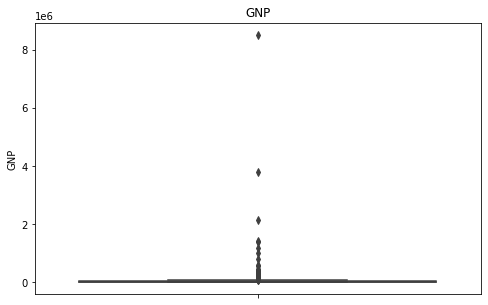

In [ ]:
sns.boxplot(y='GNP', data = df_country)
plt.title("GNP")
plt.show()

In [ ]:
pop_mask = df_country[df_country["Population"] >= 1000000].index
df = df_country.drop(pop_mask, axis = 0)

In [ ]:
gnp_mask = df[df["GNP"] >= 4000].index
df_drop = df.drop(gnp_mask, axis = 0)

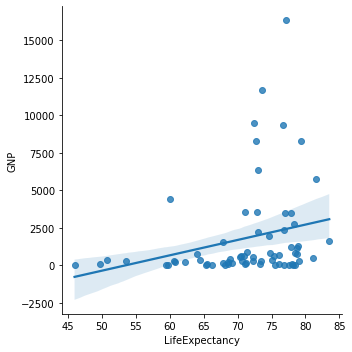

In [ ]:
sns.lmplot(x='LifeExpectancy', y='GNP', data = df)

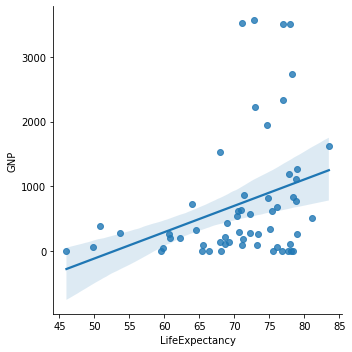

In [ ]:
sns.lmplot(x='LifeExpectancy', y='GNP', data = df_drop)

- GNP가 아웃라이어로 나타나는 국가들의 기대수명 자료를 제거하여도, 그래프상으로는 강한 상관관계를 찾기 어려웠다.